# Gaussian Process Latent Variable Model

Open processed video sample using OpenCV library:

In [3]:
import numpy as np
import cv2

w,h = 120,90

sample = np.load('data\samplevideo.npy')
print(sample[0,:])

[ 116.  121.  130. ...,  109.   67.   65.]


Function for displaying one frame:

In [4]:
def show_frame(frame):
    
    mp.imshow(frame.reshape((h,w)),cmap='Greys_r')

Plot the first frame of sample:

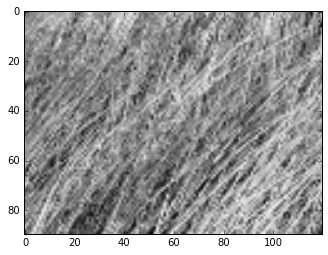

In [5]:
import matplotlib.pyplot as mp

% matplotlib inline
show_frame(sample[0,:])

Initialize all the parameters and normilize given sample:

In [6]:
N = sample.shape[0] # count of samples
D = sample.shape[1] # dimensionality of observed space
Q = 20 # dimensionality of observed space

X = np.zeros((N,Q)) # Initialize the latent variable

#normilizing data:
sample_mean = np.mean(sample, 0)
sample_std = np.std(sample, 0)
sample = (sample - sample_mean)/sample_std # normalization

print(sample)

[[-1.11651213 -1.01944808 -0.23999337 ..., -0.12147499 -1.15733176
  -1.52699203]
 [-0.28189271 -0.92650059 -0.3284865  ...,  0.78656064 -0.78029405
   1.12758945]
 [ 0.39623557 -0.8335531  -0.01876054 ...,  1.19013202  0.17680168
   3.23846147]
 ..., 
 [-2.1597864   0.14239556 -0.85944528 ...,  0.3493583  -0.72228825
   1.03164073]
 [ 1.49167355 -0.36881564 -1.25766437 ...,  0.08031071  0.98888291
   0.10413635]
 [-0.54271128  1.86192413 -0.90369185 ...,  1.02197728  0.5538394
  -0.27965856]]


Define combined kernel using GPy library:

In [7]:
import GPy

#kernel = GPy.kern.Linear(Q,ARD=True)+GPy.kern.RBF(Q,ARD=True)+GPy.kern.RatQuad(Q,ARD=True)+GPy.kern.MLP(Q,ARD=True)+GPy.kern.Matern52(Q,ARD=True)
kernel = GPy.kern.RBF(Q,ARD=True)
m = GPy.models.GPLVM(sample, input_dim=Q, kernel=kernel, init='PCA')

Optimization of the model using SCG (Warning! Minimum value for max_iters is 100, for 10000 it takes around 1 hour to perform optimization)

In [8]:
m.optimize(messages=True, optimizer = 'SCG',max_iters=100)

Extract latent X from the model:

In [9]:
X = m.X
print(X)

  index      |  GPLVM.latent_mean  |  constraints  |  priors
  [0 0]      |        -1.39909236  |               |        
  [0 1]      |         1.69129505  |               |        
  [0 2]      |        -1.11477991  |               |        
  [0 3]      |        -0.60750978  |               |        
  [0 4]      |         0.54337642  |               |        
  [0 5]      |        -2.67485944  |               |        
  [0 6]      |         0.97294169  |               |        
  [0 7]      |        -0.66348885  |               |        
  [0 8]      |         0.92961538  |               |        
  [0 9]      |        -1.26606615  |               |        
  [ 0 10]    |         0.08499501  |               |        
  [ 0 11]    |         0.44705021  |               |        
  [ 0 12]    |        -0.33970389  |               |        
  [ 0 13]    |         1.27877465  |               |        
  [ 0 14]    |        -0.82239980  |               |        
  [ 0 15]    |         0

In [11]:
# Save data to tmp file
#np.save('test_X', X)

Plot first 5 values to visualize:

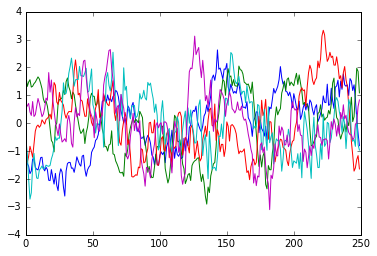

In [12]:
mp.plot(X[:,0:5])

Extract kernel matrix:

In [13]:
Kx = kernel.K(X[0:N-1])
print(Kx)

[[ 0.61081181  0.48221884  0.32226514 ...,  0.03001861  0.08628253
   0.07333117]
 [ 0.48221884  0.61081181  0.49033514 ...,  0.03051069  0.06846567
   0.05912088]
 [ 0.32226514  0.49033514  0.61081181 ...,  0.02586961  0.05945643
   0.06153896]
 ..., 
 [ 0.03001861  0.03051069  0.02586961 ...,  0.61081181  0.2784255
   0.1058438 ]
 [ 0.08628253  0.06846567  0.05945643 ...,  0.2784255   0.61081181
   0.33352484]
 [ 0.07333117  0.05912088  0.06153896 ...,  0.1058438   0.33352484
   0.61081181]]


Function to predict new artificial frame using mean prediction method:

In [14]:
def predict_new_frame(N,X,kern,Kx_inv,X_old):
    
    k_x = kern.K(X[0:N-1],X_old)
    #k_xx = kern.K(X_old,X_old)

    meann = np.matmul(np.matmul(np.transpose(X[1:N]),Kx_inv),k_x).flatten()
    #cov = (k_xx - np.matmul(np.matmul(np.transpose(k_x),Kx_inv),k_x)) * np.eye(Q)
    
    #R = np.random.multivariate_normal(meann,cov)
    R = meann
    
    return R

Perform prediciton of new X:

In [15]:
N_synt = N  #for evaluation - the same number as in the input
X_synt = np.zeros((N_synt,Q))
X_last = X[N-1:N]
Kx_inv = np.linalg.inv(Kx)

for i in range(N_synt):
    X_synt[i,:] = predict_new_frame(N,X,kernel,Kx_inv,X_last.reshape(1,Q))
    X_last = X_synt[i,:]
    
print(X_synt)

[[-0.6952685   0.58223274 -1.20029093 ...,  0.30362823 -0.60384923
  -0.96267249]
 [-0.96640944  0.67542764 -1.48762679 ...,  0.05738491 -0.28364263
  -1.20889786]
 [-1.15863524  0.60335481 -1.46345838 ..., -0.16649177 -0.05852829
  -1.13389863]
 ..., 
 [ 1.26055724 -0.74079204 -0.96689693 ..., -0.46234525  1.60812928
  -2.10108332]
 [ 1.06886099  0.19563024 -1.38343915 ..., -1.39923946  1.67780659
  -0.47617337]
 [ 1.20183565  0.60000474 -1.09656705 ..., -1.24129191 -0.2901657
  -0.45829269]]


Plot of new X:

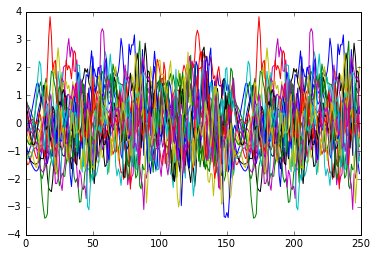

In [16]:
mp.plot(X_synt)

In [17]:
# Save data to tmp file
#np.save('test_X_synt', X_synt)

Now perform syntesis of the dinamic texture based on new X by using multivariate Gaussian:

In [18]:
Y_synt = np.zeros((N_synt,D))

kernel2 = kernel #GPy.kern.RBF(Q,ARD=True) #try original kernel
Ky = kernel2.K(X)
Ky_inv = np.linalg.inv(Ky)
Y_t = np.transpose(sample)


    
k_y = kernel2.K(X,X_synt)
k_yy = kernel2.K(X_synt,X_synt)
meann = np.matmul(np.matmul(Y_t,Ky_inv),k_y)
cov = (k_yy - np.matmul(np.matmul(np.transpose(k_y),Ky_inv),k_y))


for i in range(D):
    Y_synt[:,i] = np.matmul(cov,np.random.randn(N_synt)) + meann[i,:]

print(Y_synt)

[[-1.11792396 -0.30472596 -0.7005002  ...,  0.2402015   1.55845007
  -0.41394614]
 [-1.35545496 -1.2204578  -0.76430835 ...,  0.1610314   2.5313832
  -0.50553001]
 [-1.29658578 -1.93340622 -0.4664484  ..., -0.09009582  2.96136692
  -0.62178192]
 ..., 
 [-0.29948735 -0.59440151 -0.29017829 ..., -0.92109698 -0.2184705
  -0.83611111]
 [-0.78138582 -0.66917637  0.14876895 ...,  1.02691183  0.01603702
  -0.43439724]
 [-1.15961391 -1.07275577 -0.75742055 ...,  1.56049853  0.88433968
   0.2476495 ]]


In [19]:
# Save data to tmp file
#np.save('test_Y_synt', Y_synt)

Display first frame:

[-1.2204578  -0.76430835  0.05580184 -0.0390756 ]


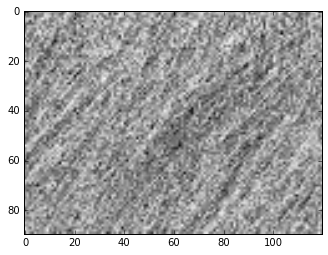

In [62]:
show_frame(Y_synt[1,:])
print(Y_synt[1,1:5])

[[ 86  88  96 ..., 110 102  86]
 [114 105 119 ...,  81 116  80]
 [ 96 109 131 ..., 119 105 103]
 ..., 
 [ 84  84 156 ..., 102 135  95]
 [ 82 102 181 ..., 155  96 137]
 [108 110 138 ..., 152 136 120]]


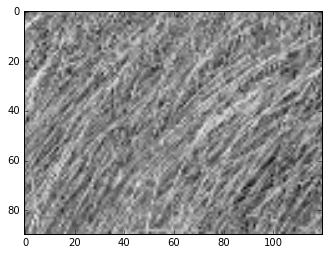

In [69]:
frame = Y_synt_denorm[i,:].reshape((h,w)).astype(np.uint8)
show_frame(frame)
print(frame)

Finally, save video:

### 0. Save as pictures

In [21]:
for i in range(N_synt):
    print(i)
    frame = Y_synt[i,:].reshape((h,w)).astype(int)
    ind = 'frame' + str(i) + '.jpg'
    mp.imsave(ind,frame,cmap='Greys_r')

cv2.destroyAllWindows()
print('Done!')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
Done!


### 1. Save as pictures using global normalization

In [22]:
max = Y_synt[:,:].max()
min = Y_synt[:,:].min()

Y_synt_denorm = (255/(max - min))*(Y_synt - min)
max = Y_synt_denorm[:,:].max()
min = Y_synt_denorm[:,:].min()
print(min, max)

0.0 255.0


In [23]:
for i in range(N_synt):
    print(i)
    frame = Y_synt_denorm[i,:].reshape((h,w)).astype(int)
    
    ind = 'data/frame' + str(i) + '.jpg'
    mp.imsave(ind,frame,cmap='Greys_r')
    #img = mp.imread('data/test.png')
    
    #out.write(img)
    #print(img)

#cap.release()
#out.release()
cv2.destroyAllWindows()
print('Done!')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
Done!


### 2. Global denormalization

In [24]:
max = Y_synt[:,:].max()
min = Y_synt[:,:].min()
print(min, max)

-4.69834006769 5.75806913512


In [25]:
Y_synt_denorm = (255/(max - min))*(Y_synt - min)
max = Y_synt_denorm[:,:].max()
min = Y_synt_denorm[:,:].min()
print(min, max)

0.0 255.0


In [27]:
cap = cv2.VideoCapture(0)
fourcc = cv2.VideoWriter_fourcc(*'DIB ')
#fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('data\output2.avi',fourcc, 25.0, (w,h))

for i in range(N_synt):
    print(i)
    frame = Y_synt_denorm[i,:].reshape((h,w)).astype(int)
    img = np.zeros((90,120,3), np.uint8)
    img[:,:,0] = frame
    img[:,:,1] = frame
    img[:,:,2] = frame
    out.write(img)
    print(img)

cap.release()
out.release()
cv2.destroyAllWindows()
print('Done!')

0
[[[ 87  87  87]
  [107 107 107]
  [ 97  97  97]
  ..., 
  [118 118 118]
  [ 93  93  93]
  [ 87  87  87]]

 [[136 136 136]
  [ 85  85  85]
  [114 114 114]
  ..., 
  [160 160 160]
  [111 111 111]
  [133 133 133]]

 [[103 103 103]
  [ 95  95  95]
  [ 91  91  91]
  ..., 
  [116 116 116]
  [ 81  81  81]
  [126 126 126]]

 ..., 
 [[156 156 156]
  [114 114 114]
  [ 94  94  94]
  ..., 
  [118 118 118]
  [162 162 162]
  [118 118 118]]

 [[151 151 151]
  [117 117 117]
  [121 121 121]
  ..., 
  [113 113 113]
  [123 123 123]
  [102 102 102]]

 [[115 115 115]
  [124 124 124]
  [105 105 105]
  ..., 
  [120 120 120]
  [152 152 152]
  [104 104 104]]]
1
[[[ 81  81  81]
  [ 84  84  84]
  [ 95  95  95]
  ..., 
  [110 110 110]
  [ 95  95  95]
  [ 92  92  92]]

 [[135 135 135]
  [ 81  81  81]
  [106 106 106]
  ..., 
  [171 171 171]
  [119 119 119]
  [136 136 136]]

 [[106 106 106]
  [ 93  93  93]
  [102 102 102]
  ..., 
  [131 131 131]
  [ 80  80  80]
  [127 127 127]]

 ..., 
 [[159 159 159]
  [121 121 1

### 3. Denormalization of every frame independently

In [28]:
max = Y_synt[:,:].max()
min = Y_synt[:,:].min()
print(min, max)

-4.69834006769 5.75806913512


In [29]:
cap = cv2.VideoCapture(0)
fourcc = cv2.VideoWriter_fourcc(*'DIB ')
#fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('data\output3.avi',fourcc, 25.0, (w,h))

for i in range(N_synt):
    print(i)
    frame = Y_synt[i,:].reshape((h,w)).astype(int)
    max = frame.max()
    min = frame.min()
    frame = (255/(max - min))*(frame - min) 
    img = np.zeros((90,120,3), np.uint8)
    img[:,:,0] = frame
    img[:,:,1] = frame
    img[:,:,2] = frame
    out.write(img)
    print(img)

cap.release()
out.release()
cv2.destroyAllWindows()
print('Done!')

0
[[[ 85  85  85]
  [127 127 127]
  [127 127 127]
  ..., 
  [127 127 127]
  [127 127 127]
  [ 85  85  85]]

 [[127 127 127]
  [ 85  85  85]
  [127 127 127]
  ..., 
  [170 170 170]
  [127 127 127]
  [127 127 127]]

 [[127 127 127]
  [127 127 127]
  [127 127 127]
  ..., 
  [127 127 127]
  [ 85  85  85]
  [127 127 127]]

 ..., 
 [[170 170 170]
  [127 127 127]
  [127 127 127]
  ..., 
  [127 127 127]
  [170 170 170]
  [127 127 127]]

 [[170 170 170]
  [127 127 127]
  [127 127 127]
  ..., 
  [127 127 127]
  [127 127 127]
  [127 127 127]]

 [[127 127 127]
  [127 127 127]
  [127 127 127]
  ..., 
  [127 127 127]
  [170 170 170]
  [127 127 127]]]
1
[[[ 85  85  85]
  [ 85  85  85]
  [127 127 127]
  ..., 
  [127 127 127]
  [127 127 127]
  [127 127 127]]

 [[127 127 127]
  [ 85  85  85]
  [127 127 127]
  ..., 
  [212 212 212]
  [127 127 127]
  [127 127 127]]

 [[127 127 127]
  [127 127 127]
  [127 127 127]
  ..., 
  [127 127 127]
  [ 85  85  85]
  [127 127 127]]

 ..., 
 [[170 170 170]
  [127 127 1

### 4. Global denormalization using mean and std from initialization step

In [30]:
max = Y_synt[:,:].max()
min = Y_synt[:,:].min()
print(min, max)

-4.69834006769 5.75806913512


In [31]:
Y_synt_demorm = sample_std * Y_synt + sample_mean
max = Y_synt_demorm[:,:].max()
min = Y_synt_demorm[:,:].min()
print(min, max)

-2.58195365757 233.289515771


In [33]:
# how to cut negative values?

In [42]:
min.astype(np.uint8)

254

In [43]:
cap = cv2.VideoCapture(0)
fourcc = cv2.VideoWriter_fourcc(*'DIB ')
#fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('data\output4.avi',fourcc, 25.0, (w,h))

for i in range(N_synt):
    print(i)
    frame = Y_synt_denorm[i,:].reshape((h,w)).astype(int)
    img = np.zeros((90,120,3), np.uint8)
    img[:,:,0] = frame
    img[:,:,1] = frame
    img[:,:,2] = frame
    out.write(img)
    print(img)

cap.release()
out.release()
cv2.destroyAllWindows()
print('Done!')

0
[[[ 87  87  87]
  [107 107 107]
  [ 97  97  97]
  ..., 
  [118 118 118]
  [ 93  93  93]
  [ 87  87  87]]

 [[136 136 136]
  [ 85  85  85]
  [114 114 114]
  ..., 
  [160 160 160]
  [111 111 111]
  [133 133 133]]

 [[103 103 103]
  [ 95  95  95]
  [ 91  91  91]
  ..., 
  [116 116 116]
  [ 81  81  81]
  [126 126 126]]

 ..., 
 [[156 156 156]
  [114 114 114]
  [ 94  94  94]
  ..., 
  [118 118 118]
  [162 162 162]
  [118 118 118]]

 [[151 151 151]
  [117 117 117]
  [121 121 121]
  ..., 
  [113 113 113]
  [123 123 123]
  [102 102 102]]

 [[115 115 115]
  [124 124 124]
  [105 105 105]
  ..., 
  [120 120 120]
  [152 152 152]
  [104 104 104]]]
1
[[[ 81  81  81]
  [ 84  84  84]
  [ 95  95  95]
  ..., 
  [110 110 110]
  [ 95  95  95]
  [ 92  92  92]]

 [[135 135 135]
  [ 81  81  81]
  [106 106 106]
  ..., 
  [171 171 171]
  [119 119 119]
  [136 136 136]]

 [[106 106 106]
  [ 93  93  93]
  [102 102 102]
  ..., 
  [131 131 131]
  [ 80  80  80]
  [127 127 127]]

 ..., 
 [[159 159 159]
  [121 121 1

### 5. Global denormalization + denormalize every frame

In [72]:
max = Y_synt[:,:].max()
min = Y_synt[:,:].min()
print(min, max)

-4.69834006769 5.75806913512


In [73]:
Y_synt_denorm = (255/(max - min))*(Y_synt - min)
max = Y_synt_denorm[:,:].max()
min = Y_synt_denorm[:,:].min()
print(min, max)

0.0 255.0


In [82]:
cap = cv2.VideoCapture(0)
fourcc = cv2.VideoWriter_fourcc(*'DIB ')
#fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('data\output5.avi',fourcc, 25.0, (w,h))

for i in range(N_synt):
    print(i)
    frame = Y_synt_denorm[i,:].reshape((h,w)).astype(int)
    max = frame.max()
    min = frame.min()
    frame = (255/(max - min))*(frame - min)    
    img = np.zeros((90,120,3), np.uint8)
    img[:,:,0] = frame
    img[:,:,1] = frame
    img[:,:,2] = frame
    out.write(img)
    print(img)

cap.release()
out.release()
cv2.destroyAllWindows()
print('Done!')

0
[[[ 76  76  76]
  [109 109 109]
  [ 93  93  93]
  ..., 
  [126 126 126]
  [ 86  86  86]
  [ 76  76  76]]

 [[155 155 155]
  [ 73  73  73]
  [120 120 120]
  ..., 
  [194 194 194]
  [115 115 115]
  [150 150 150]]

 [[102 102 102]
  [ 89  89  89]
  [ 83  83  83]
  ..., 
  [123 123 123]
  [ 67  67  67]
  [139 139 139]]

 ..., 
 [[187 187 187]
  [120 120 120]
  [ 88  88  88]
  ..., 
  [126 126 126]
  [197 197 197]
  [126 126 126]]

 [[179 179 179]
  [125 125 125]
  [131 131 131]
  ..., 
  [118 118 118]
  [134 134 134]
  [101 101 101]]

 [[121 121 121]
  [136 136 136]
  [105 105 105]
  ..., 
  [129 129 129]
  [181 181 181]
  [104 104 104]]]
1
[[[ 81  81  81]
  [ 85  85  85]
  [101 101 101]
  ..., 
  [123 123 123]
  [101 101 101]
  [ 97  97  97]]

 [[160 160 160]
  [ 81  81  81]
  [117 117 117]
  ..., 
  [213 213 213]
  [137 137 137]
  [162 162 162]]

 [[117 117 117]
  [ 98  98  98]
  [112 112 112]
  ..., 
  [154 154 154]
  [ 79  79  79]
  [148 148 148]]

 ..., 
 [[196 196 196]
  [140 140 1

### 6. Global denormalization + auto levels

In [75]:
max = Y_synt[:,:].max()
min = Y_synt[:,:].min()
print(min, max)

-4.69834006769 5.75806913512


In [76]:
Y_synt_denorm = (255/(max - min))*(Y_synt - min)
max = Y_synt_denorm[:,:].max()
min = Y_synt_denorm[:,:].min()
print(min, max)

0.0 255.0


In [77]:
cap = cv2.VideoCapture(0)
fourcc = cv2.VideoWriter_fourcc(*'DIB ')
#fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('data\output6.avi',fourcc, 25.0, (w,h))

for i in range(N_synt):
    print(i)
    frame = Y_synt_denorm[i,:].reshape((h,w)).astype(np.uint8)  
    equ = cv2.equalizeHist(frame)
    img = np.zeros((90,120,3), np.uint8)
    img[:,:,0] = equ
    img[:,:,1] = equ
    img[:,:,2] = equ
    out.write(img)
    print(img)

cap.release()
out.release()
cv2.destroyAllWindows()
print('Done!')

0
[[[ 33  33  33]
  [110 110 110]
  [ 66  66  66]
  ..., 
  [162 162 162]
  [ 51  51  51]
  [ 33  33  33]]

 [[225 225 225]
  [ 29  29  29]
  [143 143 143]
  ..., 
  [252 252 252]
  [128 128 128]
  [217 217 217]]

 [[ 92  92  92]
  [ 58  58  58]
  [ 45  45  45]
  ..., 
  [153 153 153]
  [ 20  20  20]
  [194 194 194]]

 ..., 
 [[251 251 251]
  [143 143 143]
  [ 54  54  54]
  ..., 
  [162 162 162]
  [253 253 253]
  [162 162 162]]

 [[248 248 248]
  [157 157 157]
  [175 175 175]
  ..., 
  [139 139 139]
  [183 183 183]
  [ 87  87  87]]

 [[148 148 148]
  [187 187 187]
  [101 101 101]
  ..., 
  [171 171 171]
  [249 249 249]
  [ 96  96  96]]]
1
[[[ 26  26  26]
  [ 32  32  32]
  [ 63  63  63]
  ..., 
  [123 123 123]
  [ 63  63  63]
  [ 53  53  53]]

 [[214 214 214]
  [ 26  26  26]
  [107 107 107]
  ..., 
  [254 254 254]
  [159 159 159]
  [216 216 216]]

 [[107 107 107]
  [ 56  56  56]
  [ 90  90  90]
  ..., 
  [202 202 202]
  [ 24  24  24]
  [190 190 190]]

 ..., 
 [[250 250 250]
  [167 167 1

### 7. Global denormalization + denormalize every frame + auto levels

In [79]:
max = Y_synt[:,:].max()
min = Y_synt[:,:].min()
print(min, max)

-4.69834006769 5.75806913512


In [80]:
Y_synt_denorm = (255/(max - min))*(Y_synt - min)
max = Y_synt_denorm[:,:].max()
min = Y_synt_denorm[:,:].min()
print(min, max)

0.0 255.0


In [83]:
cap = cv2.VideoCapture(0)
fourcc = cv2.VideoWriter_fourcc(*'DIB ')
#fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('data\output7.avi',fourcc, 25.0, (w,h))

for i in range(N_synt):
    print(i)
    frame = Y_synt_denorm[i,:].reshape((h,w)).astype(int)
    max = frame.max()
    min = frame.min()
    frame = (255/(max - min))*(frame - min)    
    frame = frame.astype(np.uint8)  
    equ = cv2.equalizeHist(frame)
    img = np.zeros((90,120,3), np.uint8)
    img[:,:,0] = equ
    img[:,:,1] = equ
    img[:,:,2] = equ
    out.write(img)
    print(img)

cap.release()
out.release()
cv2.destroyAllWindows()
print('Done!')

0
[[[ 33  33  33]
  [110 110 110]
  [ 66  66  66]
  ..., 
  [162 162 162]
  [ 51  51  51]
  [ 33  33  33]]

 [[225 225 225]
  [ 29  29  29]
  [143 143 143]
  ..., 
  [252 252 252]
  [128 128 128]
  [217 217 217]]

 [[ 92  92  92]
  [ 58  58  58]
  [ 45  45  45]
  ..., 
  [153 153 153]
  [ 20  20  20]
  [194 194 194]]

 ..., 
 [[251 251 251]
  [143 143 143]
  [ 54  54  54]
  ..., 
  [162 162 162]
  [253 253 253]
  [162 162 162]]

 [[248 248 248]
  [157 157 157]
  [175 175 175]
  ..., 
  [139 139 139]
  [183 183 183]
  [ 87  87  87]]

 [[148 148 148]
  [187 187 187]
  [101 101 101]
  ..., 
  [171 171 171]
  [249 249 249]
  [ 96  96  96]]]
1
[[[ 26  26  26]
  [ 32  32  32]
  [ 63  63  63]
  ..., 
  [123 123 123]
  [ 63  63  63]
  [ 53  53  53]]

 [[214 214 214]
  [ 26  26  26]
  [107 107 107]
  ..., 
  [254 254 254]
  [159 159 159]
  [216 216 216]]

 [[107 107 107]
  [ 56  56  56]
  [ 90  90  90]
  ..., 
  [202 202 202]
  [ 24  24  24]
  [190 190 190]]

 ..., 
 [[250 250 250]
  [167 167 1